In [1]:
from dasi.design import Design

import warnings

from Bio import BiopythonParserWarning
warnings.simplefilter('ignore', BiopythonParserWarning)

In [2]:
from dasi.design import Design
from pyblast.utils import load_fasta_glob, load_genbank_glob, make_circular, make_linear
from dasi.cost import SpanCost
from os.path import join

span_cost = SpanCost()


here = '../tests'
query = '*.gb'
paths = {
        'primers': join(here, "data/test_data/primers/primers.fasta"),
        'templates': join(here, "data/test_data/genbank/templates/*.gb"),
        'queries': join(
            'tests', "data/test_data/genbank/designs/*.gb"
        ),
    }
primers = make_linear(load_fasta_glob(paths["primers"]))
templates = load_genbank_glob(paths["templates"])

query_path = join(here, 'data/test_data/genbank/designs', query)
queries = make_circular(load_genbank_glob(query_path))

/Users/justinvrana/Documents/GitHub/DASi-DNA-Design/dasi/cost/__init__.py:132: RuntimeWarning: divide by zero encountered in true_divide
  self.cost_matrix = (m * CostParams.material + t * CostParams.time) * 1.0 / e


In [6]:
from dasi.design import Design

design = Design(span_cost)
design.add_materials(primers=primers, templates=templates, queries=queries)
design.logger.set_level("INFO")
design.compile()

INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:51,992 - Compiling assembly graph
INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:52,952 - Number of template matches: 600
INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:52,954 - Number of perfect fragment matches: 0
INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,334 - Number of perfect primers: 439


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,411 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,415 - Number of groups: 1337


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,716 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,720 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 278
Number of edges: 3459
Average in degree:  12.4424
Average out degree:  12.4424


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,757 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:54,762 - Number of groups: 842


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,063 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,068 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 330
Number of edges: 3601
Average in degree:  10.9121
Average out degree:  10.9121


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,161 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,165 - Number of groups: 1223


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,610 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,614 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 360
Number of edges: 3915
Average in degree:  10.8750
Average out degree:  10.8750


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,897 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:55,901 - Number of groups: 6797


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:58,854 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:58,859 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 720
Number of edges: 8268
Average in degree:  11.4833
Average out degree:  11.4833


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:58,907 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:58,913 - Number of groups: 913


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,191 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,196 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 302
Number of edges: 3347
Average in degree:  11.0828
Average out degree:  11.0828


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,323 - Number of types: 7


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,328 - Number of groups: 1324


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,605 - === Assembly Graph ===


INFO - <class 'dasi.design.Design'>(id=112445688408) - 2019-09-01 08:32:59,609 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 268
Number of edges: 3289
Average in degree:  12.2724
Average out degree:  12.2724


INFO     compiling all containers: 100%|██████████| 6/6 [00:05<00:00,  1.23it/s]


AttributeError: 'Design' object has no attribute 'containers'

In [3]:
from dasi.design import LibraryDesign
from more_itertools import pairwise

design = LibraryDesign(span_cost=span_cost)

design.add_materials(primers=primers, templates=templates, queries=queries)

design.compile()
path_dict = design.optimize()
path_dict

for qk, graph in design.graphs.items():
    cost = 0
    for n1, n2 in pairwise(path_dict[qk][0]):
        edata = graph[n1][n2]
        cost += edata['weight']
    print("{}: {}".format(qk, cost))

a3e4297a-e81c-41ae-942c-95e5acf32398: 808.6944444444445
f7172293-e630-42f7-850f-a11736a46488: 1775.111111111111
5bc6e3b0-6707-419b-aa2f-b60c129c17e3: 1746.0
fe89aa3d-5b50-4ff3-9f53-d99a5772cb9e: 2761.222222222222
4014d822-486e-45bb-88a9-86c0989965ba: 324.55555555555554


In [4]:
from dasi.design import LibraryDesign
from more_itertools import pairwise

design = LibraryDesign(span_cost=span_cost)

design.add_materials(primers=primers, templates=templates, queries=queries)

design.compile_library()

path_dict = design.optimize()
path_dict

for qk, graph in design.graphs.items():
    cost = 0
    for n1, n2 in pairwise(path_dict[qk][0]):
        edata = graph[n1][n2]
        cost += edata['weight']
    print("{}: {}".format(qk, cost))

/Users/justinvrana/anaconda/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 56e81a3a-c174-4c93-9264-2f5a32604cee overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject 56e81a3a-c174-4c93-9264-2f5a32604cee overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query b6ae27be-50c3-4e9a-a2b9-8564c342c0e9 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject b6ae27be-50c3-4e9a-a2b9-8564c342c0e9 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 847594eb-518a-4f66-95e5-cf7eaeebfeb8 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda/lib/python3.7/site

56e81a3a-c174-4c93-9264-2f5a32604cee: 808.6944444444445
b6ae27be-50c3-4e9a-a2b9-8564c342c0e9: 1775.111111111111
847594eb-518a-4f66-95e5-cf7eaeebfeb8: 1746.0
ac8afd8a-2df1-4fae-9df0-70577e641e59: 2761.222222222222
49fa258d-6ffd-4fab-aef2-4fc9717fabff: 324.55555555555554


In [5]:
df = design.design()
df[0]



,cost,fragment_length,fragment_seq,query,query_name,query_region,subject,subject_name,subject_region,type
0,0.000000,777,GGCCGCGTTGCTGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAG...,56e81a3a-c174-4c93-9264-2f5a32604cee,pINS-01-hU6-SV40.NT1-op,"(494, 1271)",759ba53c-9ce5-485d-9988-e8e9aa11fbbb,ColE1_origin,"(0, 777)",PRE-MADE DNA FRAGMENT
1,353.250000,141,TTACCAATGCTTAATCAGTGAGGCACCTATCTCAGCGATCTGTCTA...,56e81a3a-c174-4c93-9264-2f5a32604cee,pINS-01-hU6-SV40.NT1-op,"(1271, 1432)",None,SYNTHESIS,None,JUNCTION_BY_PRIMERS
2,90.000000,3372,CAGATTTATCAGCAATAAACCAGCCAGCCGGAAGGGCCGAGCGCAG...,56e81a3a-c174-4c93-9264-2f5a32604cee,pINS-01-hU6-SV40.NT1-op,"(1432, 25)",598a5804-013d-4bb1-8749-ce65a45623c9,pINS-0A1-pEF1a-citrine-,"(0, 3372)",PCR_PRODUCT
3,365.444444,449,CCTATTTCCCATGATTCCTTCATATTTGCATATACGATACAAGGCT...,56e81a3a-c174-4c93-9264-2f5a32604cee,pINS-01-hU6-SV40.NT1-op,"(25, 494)",None,SYNTHESIS,None,JUNCTION_BY_SYNTHESIS
4,60.000000,2504,?,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(0, 2504)","[f968ab95-9fa8-4d2d-ac7b-8bed2cd2fe72, 6b478a4...","[(C, A, T, C, G, C, C, C, A, C, A, G, T, C, C,...",?,PCR_PRODUCT_WITH_LEFT_PRIMER
5,107.333333,10,TAGGAACTTC,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(2504, 2514)",None,SYNTHESIS,None,JUNCTION_BY_PRIMERS
6,90.000000,1414,GTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGG...,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(2514, 3928)",598a5804-013d-4bb1-8749-ce65a45623c9,pINS-0A1-pEF1a-citrine-,"(4554, 5968)",PCR_PRODUCT
7,122.666667,56,CGCCCGCCCCACGACCCGCAGCGCCCGACCGAAAGGAGCGCACGAC...,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(3928, 3984)",None,SYNTHESIS,None,JUNCTION_BY_PRIMERS
8,90.000000,674,GGTACCTTTAAGACCAATGACTTACAAGGCAGCTGTAGATCTTAGC...,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(3984, 4658)",34ea8581-dfdf-4900-a72f-c999e9565f33,pCW57.1,"(4815, 5489)",PCR_PRODUCT
9,456.333333,686,AGGGACGTACCCAATTCGCCCTATAGTGAGTCGTATTACGCGCGCT...,b6ae27be-50c3-4e9a-a2b9-8564c342c0e9,pLKO-pEF1a-FRT-Citrine-,"(4658, 5344)",None,SYNTHESIS,None,JUNCTION_BY_SYNTHESIS


In [ ]:
design.co

In [82]:
from dasi import Constants
import networkx as nx
from itertools import product
from more_itertools import pairwise

%matplotlib inline

def alignment_to_nodes(align):
    n1 = (align.query_key, align.query_region.a, align.query_region.b)
    n2 = (align.subject_key, align.subject_region.a, align.subject_region.b)
    return n1, n2

# G = nx.Graph()
# for k, v in non_repeat_interactions.items():
#     for _v in v:
#         G.add_edge(k, _v)
G = nx.Graph()


def get_subgraphs(graph):
        """Get independent subgraphs"""
        node_list = list(graph.nodes)
        subgraphs = []
        while len(node_list) > 0:
            node = node_list[-1]
            if issubclass(type(graph), nx.DiGraph):
                graph = to_undirected(graph)
            subgraph = nx.bfs_tree(graph, node)
            for n in subgraph.nodes:
                node_list.remove(n)
            subgraphs.append(graph.subgraph(subgraph.nodes))
        return subgraphs

def get_shared_edges(design):
    G = nx.Graph()
    for container in design.container_list():
        alignments = container.get_alignments_by_types(Constants.SHARED_FRAGMENT)
        for align in alignments:
            qk = align.query_key
            sk = align.subject_key
            if qk != sk:
                n1, n2 = alignment_to_nodes(align)
                G.add_node(n1)
                G.add_node(n2)
                children =  list(nx.dfs_preorder_nodes(G, source=n1))
                for n3 in children:
                    if n1 != n3:
                        G.add_edge(n2, n3)
                G.add_edge(n1, n2)
    
    subgraphs = get_subgraphs(G)
    edge_enumerations = []
    all_edges = []
    for subgraph in subgraphs:
        edges = subgraph.edges()
        all_edges += edges
    return all_edges
#     enumerations = product([0, 1], repeat=len(edges))
#     print("Edges: " + str(len(edges)))
#     print("Enumerations: " + str(len(list(enumerations))))


def path_to_cost(path, graph):
    cost = 0
    for n1, n2 in pairwise(path):
        edata = graph[n1][n2]
        cost += edata['weight']
    return cost

def total_design_cost(design):
    path_dict = design.optimize()
    cost = 0
    for qk, paths in path_dict.items():
        path = paths[0]
        graph = design.graphs[qk]
        cost += path_to_cost(path, graph)
    return cost



# all_edges = get_shared_edges(design)

# from copy import deepcopy

# for qk, graph in design.graphs.items():
#     # mask graph
#     graph = deepcopy(graph)
#     for n1, n2 in all_edges:
#         if n1[0] == qk:
#             node1 = (n1[1], True, 'A')
#             node2 = (n1[2], True, 'B')
#             try:
#                 edata = graph[node1][node2]
#                 edata
#             except KeyError:
#                 print("MISSING")
            
# # nx.draw(G, node_size=10)

In [92]:
from dasi.design import LibraryDesign

design1 = LibraryDesign(span_cost=span_cost)
design2 = LibraryDesign(span_cost=span_cost)
design1.add_materials(primers=primers, templates=templates, queries=queries)
design2.add_materials(primers=primers, templates=templates, queries=queries)

design1.compile_library()
design2.logger.set_level("INFO")
design2.compile_library()

/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query b2c6eaf7-ea8b-4176-8ac5-b72a57e5331b overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject b2c6eaf7-ea8b-4176-8ac5-b72a57e5331b overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 947822d3-b88b-47e8-b385-a67829e22056 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject 947822d3-b88b-47e8-b385-a67829e22056 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 1be089ae-2e3f-4a8d-a469-c0a893cebc51 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.

INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:31,927 - Compiling assembly graph
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,265 - Number of perfect primers: 378
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,323 - === Expanding shared library fragments ===


/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 29bbaf31-da17-49e1-8ac9-3915af18ef5f overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject 29bbaf31-da17-49e1-8ac9-3915af18ef5f overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query f493ed55-20ce-4191-a058-f99a1c3581ae overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular subject f493ed55-20ce-4191-a058-f99a1c3581ae overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.7/site-packages/pyblast/blast/blast.py:605: UserWarning: A circular query 71ec6518-ffc1-46af-ba7c-1c0923e57537 overlapped the origins
  x, origin_key
/Users/justinvrana/anaconda3/lib/python3.

INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,512 - Found 67 shared alignments between the queries
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,552 - 29bbaf31-da17-49e1-8ac9-3915af18ef5f: Expanded 44 shared from original 15 shared fragments
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,574 - 29bbaf31-da17-49e1-8ac9-3915af18ef5f: Expanded PCR_PRODUCT using FRAGMENT_SHARED_WITH_OTHER_QUERIES and found 532 new alignments.
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,604 - 29bbaf31-da17-49e1-8ac9-3915af18ef5f: Expanded 513 PRODUCTS_WITH_PRIMERS using FRAGMENT_SHARED_WITH_OTHER_QUERIES
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,611 - f493ed55-20ce-4191-a058-f99a1c3581ae: Expanded 39 shared from original 12 shared fragments
INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,658 -

INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,896 - Number of types: 7


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:34,901 - Number of groups: 257


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,026 - === Assembly Graph ===


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,034 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 118
Number of edges: 1406
Average in degree:  11.9153
Average out degree:  11.9153


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,099 - Number of types: 7


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,103 - Number of groups: 317


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,199 - === Assembly Graph ===


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,204 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 134
Number of edges: 1651
Average in degree:  12.3209
Average out degree:  12.3209


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,333 - Number of types: 7


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,342 - Number of groups: 600


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,440 - === Assembly Graph ===


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,446 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 115
Number of edges: 1521
Average in degree:  13.2261
Average out degree:  13.2261


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,476 - Number of types: 7


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,481 - Number of groups: 258


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,560 - === Assembly Graph ===


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,569 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 125
Number of edges: 1524
Average in degree:  12.1920
Average out degree:  12.1920


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,633 - Number of types: 7


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,639 - Number of groups: 247


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,702 - === Assembly Graph ===


INFO - <class 'dasi.design.LibraryDesign'>(id=112118783784) - 2019-08-16 16:00:35,707 - Name: Assembly Graph
Type: DiGraph
Number of nodes: 79
Number of edges: 949
Average in degree:  12.0127
Average out degree:  12.0127


INFO     compiling all containers: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


In [91]:
for qk, graph in design2.graphs.items():
    container = design2.container_factory.containers()[qk]
    
    groups = container.get_groups_by_types(Constants.SHARED_FRAGMENT)
    print(len(groups))

15
12
1
11
2


In [84]:
all_edges = get_shared_edges(design2)

from copy import deepcopy

for qk, graph in design2.graphs.items():
    for n1, n2 in all_edges:
        if n1[0] == qk or n2[0] == qk:
            node1 = (n1[1], True, 'A')
            node2 = (n1[2], True, 'B')
            
            print(node1, node2)
            try:
                edata = graph[node1][node2]
                edata['weight'] = 0
                print("found")
            except KeyError:
                print("Missing")
            
print(total_design_cost(design1))
print(total_design_cost(design2))

(7330, True, 'A') (7364, True, 'B')
found
(7330, True, 'A') (7364, True, 'B')
found
(7330, True, 'A') (7364, True, 'B')
found
(3228, True, 'A') (7009, True, 'B')
Missing
(4355, True, 'A') (8136, True, 'B')
Missing
(8792, True, 'A') (3759, True, 'B')
Missing
(0, True, 'A') (3605, True, 'B')
Missing
(3759, True, 'A') (7364, True, 'B')
Missing
(4377, True, 'A') (8136, True, 'B')
Missing
(0, True, 'A') (3759, True, 'B')
Missing
(4377, True, 'A') (3605, True, 'B')
Missing
(0, True, 'A') (7364, True, 'B')
Missing
(8792, True, 'A') (7364, True, 'B')
Missing
(8792, True, 'A') (7364, True, 'B')
Missing
(3206, True, 'A') (3250, True, 'B')
Missing
(8770, True, 'A') (8814, True, 'B')
found
(3250, True, 'A') (8100, True, 'B')
Missing
(0, True, 'A') (4850, True, 'B')
Missing
(3206, True, 'A') (8100, True, 'B')
Missing
(8770, True, 'A') (4850, True, 'B')
Missing
(4954, True, 'A') (5031, True, 'B')
Missing
(4954, True, 'A') (5031, True, 'B')
Missing
(3984, True, 'A') (4061, True, 'B')
Missing
(3984, T

In [80]:
design1.container_list()

In [71]:
total_design_cost(design2)

7665.722222222223

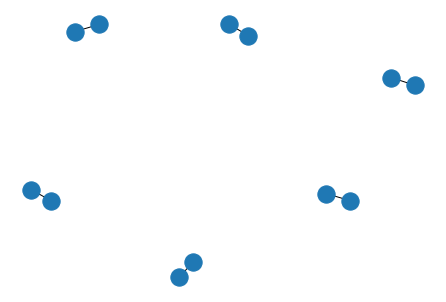

In [8]:
import networkx as nx
from itertools import product

def find(a, b, alignments):
    for align in alignments:
        if a == align.query_region.a and b == align.query_region.b:
            yield align

            
G = nx.MultiGraph()

repeats = []

for r in design.shared_alignments:
    qk = r['query']['origin_key']
    sk = r['subject']['origin_key']
    if qk == sk:
        repeats.append((qk, r['query']['start'], r['query']['end']))

non_repeat_interactions = {}

for r in design.shared_alignments:
    qk = r['query']['origin_key']
    sk = r['subject']['origin_key']
    
    if qk != sk:
        n1 = (sk, r['subject']['start'], r['subject']['end'])
        n2 = (qk, r['query']['start'], r['query']['end'])
        if n1 not in repeats and n2 not in repeats:
            query = design.container_factory.seqdb[qk]
            subject = design.container_factory.seqdb[sk]
            
            s1, e1 = r['query']['start'], r['query']['end']
            s2, e2 = r['subject']['start'], r['subject']['end']
            
            non_repeat_interactions.setdefault(n1, set()).add(n2)
            non_repeat_interactions.setdefault(n2, set()).add(n1)

G = nx.Graph()
for k, v in non_repeat_interactions.items():
    for _v in v:
        G.add_edge(k, _v)
        
%matplotlib inline

nx.draw(G)
#             print(r['subject']['start'], r['subject']['end'])
#             print(query.name, subject.name)

In [33]:
from dasi import AlignmentContainer

AlignmentContainer()

dasi.AlignmentContainer

In [6]:
queries

[SeqRecord(seq=Seq('AGTAATAGTGACTATGTTGCTCCTTTTACGCTATGTGGATACGCTGCTTTAATG...TCA', IUPACAmbiguousDNA()), id='pLKO-pEF1a-FRT-tdTomato', name='pLKO-pEF1a-FRT-tdTomato', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCTCCCGGAGA...GTC', IUPACAmbiguousDNA()), id='pMODKan-HO-pACT1-Z4-', name='pMODKan-HO-pACT1-Z4-', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('GCCGATACGAAGGTTTTCTCCAGCGAAGGTCGGGCAGGAAGAGGGCCTATTTCC...TGC', IUPACAmbiguousDNA()), id='pINS-01-hU6-SV40.NT1-op', name='pINS-01-hU6-SV40.NT1-op', description='', dbxrefs=[])]

In [10]:
for i in range(200):
    for g in design.graphs.values():
        nodelist = list(g.nodes())
        nx.floyd_warshall_numpy(g, nodelist=nodelist, weight='weight')

In [12]:
design = Design(span_cost=span_cost)

design.add_materials(primers=primers, templates=templates, queries=queries)

design.compile()
design._edges

CMD: makeblastdb -dbtype nucl -title 3d8bacc7-bade-4027-b482-d960228270db -out /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpxs_z4hlp/3d8bacc7-bade-4027-b482-d960228270db -in /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpxeb9j68w.fasta
CMD: blastn -db /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpxs_z4hlp/3d8bacc7-bade-4027-b482-d960228270db -out /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpxs_z4hlp/tmpigw0bmmw -query /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpql37_lej.fasta -outfmt "7 qacc sacc score evalue bitscore length nident gapopen gaps qlen qstart qend slen sstart send sstrand qseq sseq"
CMD: makeblastdb -dbtype nucl -title 084292af-5ab1-4f8f-8738-c79e4c8a1fac -out /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpzicbbq87/084292af-5ab1-4f8f-8738-c79e4c8a1fac -in /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmptupf1p9o.fasta
CMD: blastn -db /var/folders/hl/pff9rjpd5jx73ylds97m2hww0000gn/T/tmpzicbbq87/084292af-5ab1-4f8f-8738-c79e4c8a1fac -

AttributeError: 'Design' object has no attribute '_edges'